# David Fox - EV usage and revenue data exploration
By performing dataframe manipulations, aggregations, and basic investigations I evaluate the differences in revenue over the different station locations

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit


from sklearn.impute import SimpleImputer

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import make_scorer

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator



import datetime

from sklearn import set_config
set_config(display='diagram') 

plt.rcParams['figure.figsize'] = [20, 20]

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')


sns.set(rc={'figure.figsize':(20, 10)})
sns.set_context("poster")
sns.set_style("white")
palette = sns.color_palette("mako_r", 6)

In [7]:
def import_data():
    # charging session data 
    
    df1 = pd.read_csv('data/Fort Collins Utilities EV Data June 2020 to June 2021.csv')
    
    df2 = pd.read_csv('data/Fort Collins Utilities EV Data June 25 2021 to July 20 2021.csv')
   
    df3 = pd.read_csv('data/FCU EV Charging Transaction Data July 20 2021 to Sept 2021.csv')
    
    return pd.concat([df1, df2, df3])

In [8]:
df = import_data()

In [13]:
df = (df.rename(columns={'Session/Reservation Start Date': 'Date'})
         .set_index(pd.to_datetime(df['Date']))
         .dropna(how='all')
     )

In [68]:
df2 =  ( df.groupby('Station Name')['Net Revenue'].resample('1D').sum().reset_index()
             .assign(Station_Name = lambda x: x['Station Name'].str.replace('FORT COLLINS /',''))
             .set_index('Date')
             .assign(Date = lambda x: x.index)
        )



In [69]:
df2['revenue_7D'] = df2.groupby('Station Name')['Net Revenue'].transform(lambda x: 
                                                      x.rolling('7D', closed='both', center=True).mean())

In [70]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3495 entries, 2020-06-25 to 2021-09-28
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Station Name  3495 non-null   object        
 1   Net Revenue   3495 non-null   float64       
 2   Station_Name  3495 non-null   object        
 3   Date          3495 non-null   datetime64[ns]
 4   revenue_7D    3495 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 163.8+ KB


### Weekly moving average applied to the revenue generated from each of the stations

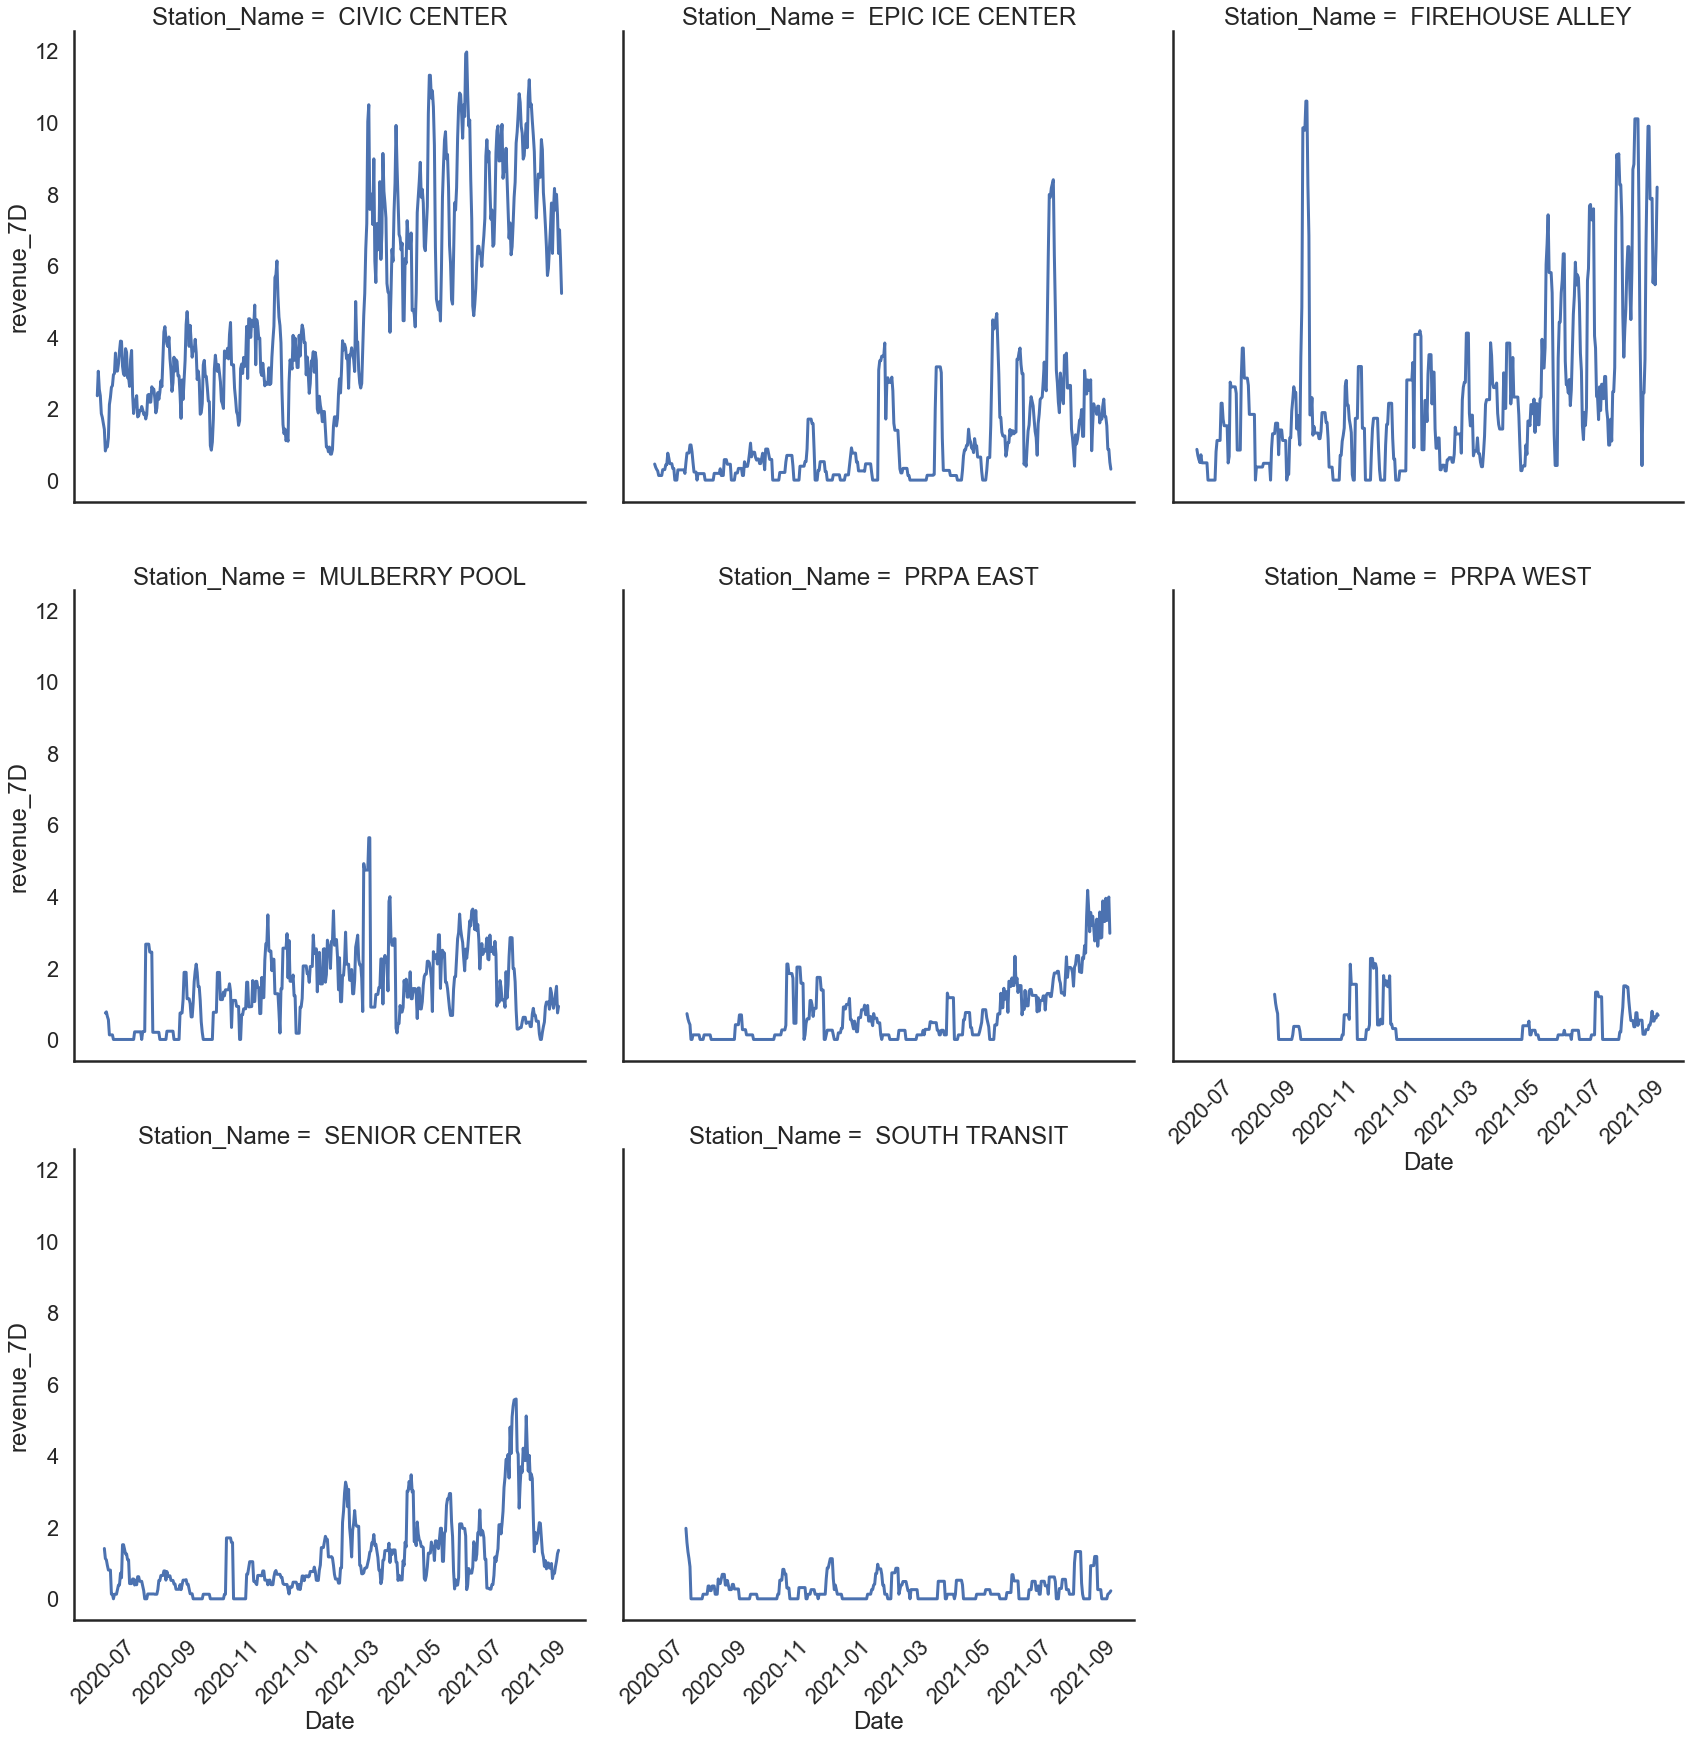

In [71]:
with sns.axes_style("white"):
    g = sns.FacetGrid(df2, col="Station_Name", margin_titles=True, 
                      height=8, sharey=True, col_wrap=3)
    
g.map(sns.lineplot, "Date", "revenue_7D")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45);
    

# Now I will perform some more aggregations to obtain weekly stats over the stations to identify the best and worst performing stations

In [61]:
test =  df.groupby('Station Name')['Net Revenue'].resample('1D').size().reset_index()

In [62]:
last7days = test[test["Date"] >= (test.iloc[-1]['Date'] - pd.Timedelta(days=7))]

Text(0.5, 1.0, 'number of visits at each station over the last week')

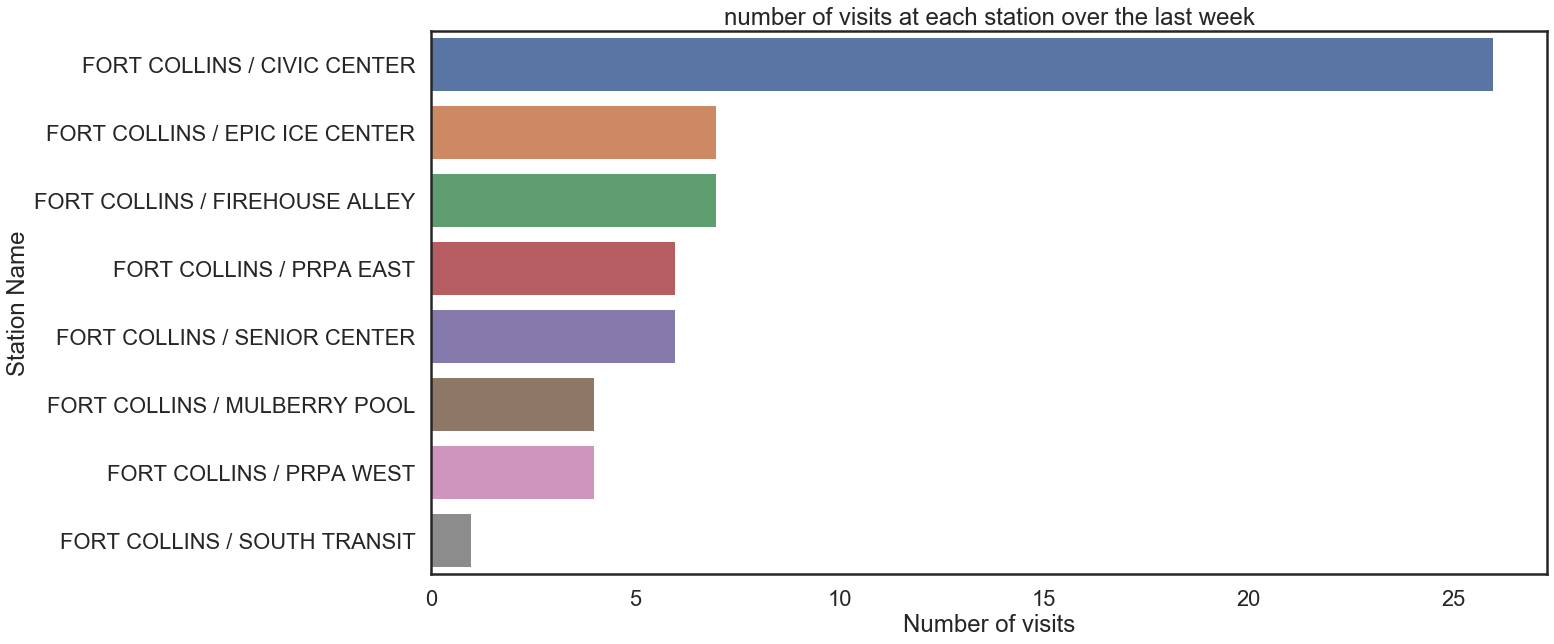

In [63]:
test2 = ( last7days.groupby('Station Name')['Net Revenue'].sum()
                                                     .reset_index()
                                                     .rename(columns={'Net Revenue' : 'Number of visits'})
                                                     .sort_values(by='Number of visits', ascending=False)
        )
ax = sns.barplot(x="Number of visits", y="Station Name", data=test2, capsize=.2)    
plt.title("number of visits at each station over the last week")

### civic center is getting 26 sessions in the last week, whereas the station at South Transit is hardly being used! This station is probably not worth the money!
The next lowest are PRPA west and Mulberry pool. Inspecting the revenue over time, it looks like PRPA west is consistently low, but the station at Mulberry pool seems to be experiencing only a temporary decrease in revenue.

# Show weekly revenue from each station in the last week

In [73]:
last7days = df2[df2["Date"] >= (df2.iloc[-1]['Date'] - pd.Timedelta(days=7))]


Text(0.5, 1.0, 'Weekly Total Revenue By Station')

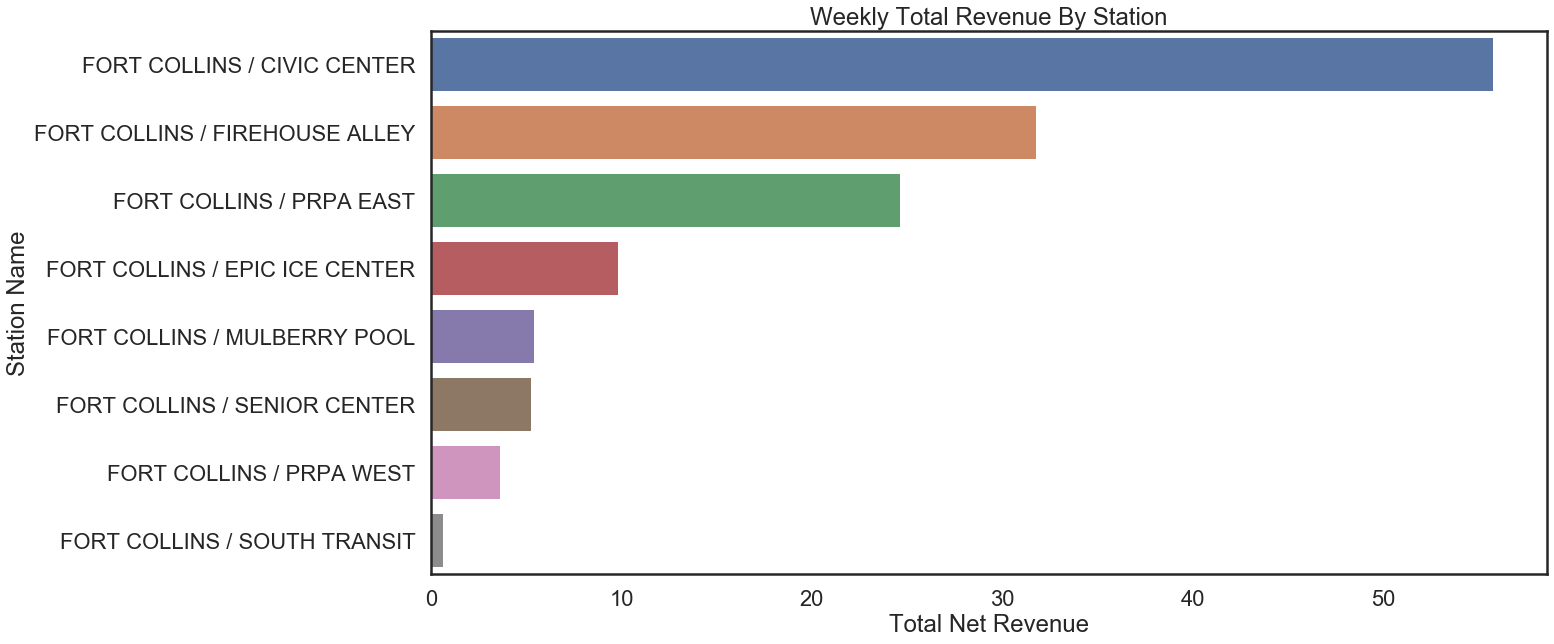

In [75]:
test2 = ( last7days.groupby('Station Name')['revenue_7D'].sum()
                                                     .reset_index()
                                                     .rename(columns={'revenue_7D' : 'Total Net Revenue'})
                                                     .sort_values(by='Total Net Revenue', ascending=False)
        )
ax = sns.barplot(x="Total Net Revenue", y="Station Name", data=test2, capsize=.2)   
plt.title('Weekly Total Revenue By Station')

# plot the average duration of charging sessions per station and per weekday and weekend

In [76]:
df['duration'] = (pd.to_datetime(df['Session/Reservation End Date'].str[:-6]) - pd.to_datetime(df['Date'])) / pd.Timedelta(hours=1)

In [77]:
test =  df.groupby('Station Name')['duration'].resample('1D').mean().reset_index()

In [88]:
last7days = test[test["Date"] >= (test.iloc[-1]['Date'] - pd.Timedelta(days=7))]

In [89]:
last7days['is_weekend'] = last7days['Date'].dt.dayofweek > 4

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Average duration By Station over the last week')

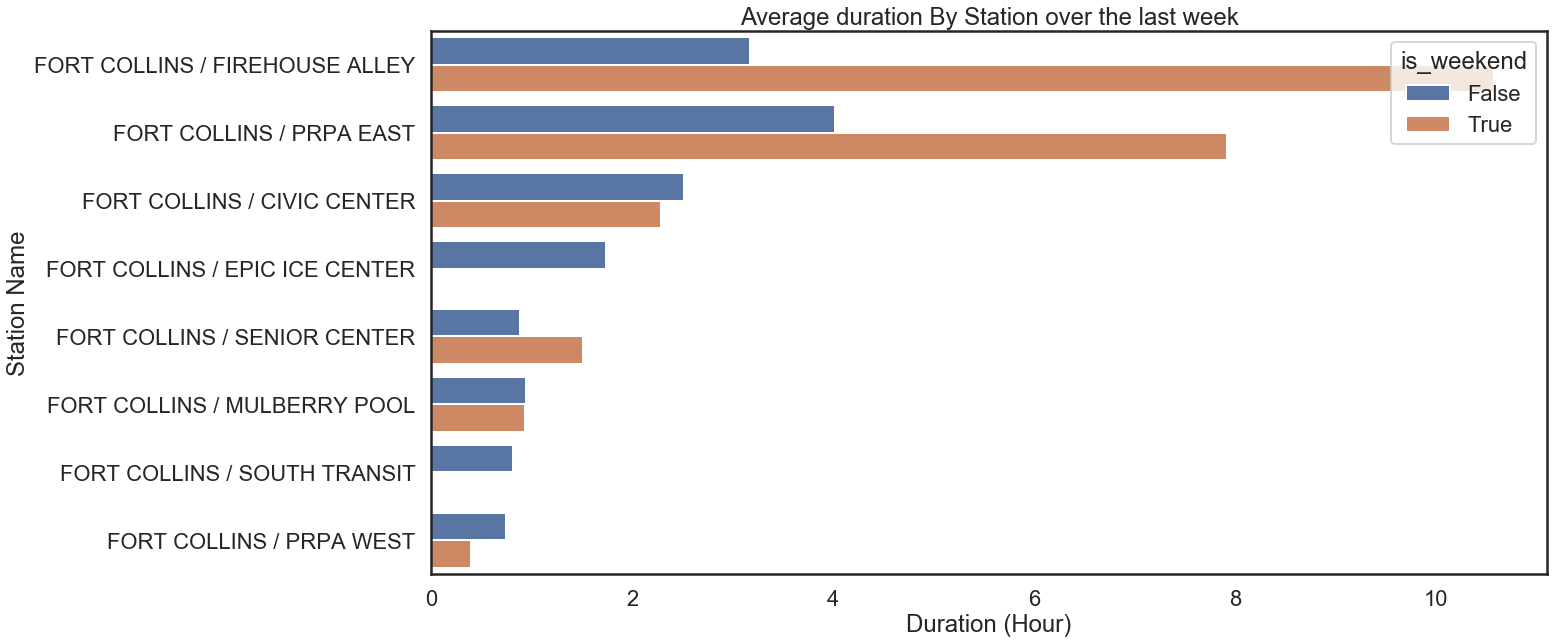

In [92]:
test2 = ( last7days.groupby(['Station Name', 'is_weekend'])['duration'].mean()
                                                     .reset_index()
                                                     .rename(columns={'duration' : 'Duration (Hour)'})
                                                     .sort_values(by='Duration (Hour)', ascending=False)
        )
ax = sns.barplot(x="Duration (Hour)", y="Station Name", hue='is_weekend', data=test2, capsize=.2)   
plt.title('Average duration By Station over the last week')

### individual charging sessions are the same or longer on the weekend compared to that for the working weekday.
This is the case for the following stations:
- Firehouse Alley
- PRPA East
- Civic Center
- Senior Center
- Mulberry Pool

For some reason in the last week, the stations located at the ice center and south transit were not used on the weekend. PRPA West station seems to be used more during weekdays suggesting to me that it is not located close to places of public gathering or local business.


# Total amount of money collected from individually and collectively is larger during the summer months.
This is why month of the year should be included as a feature

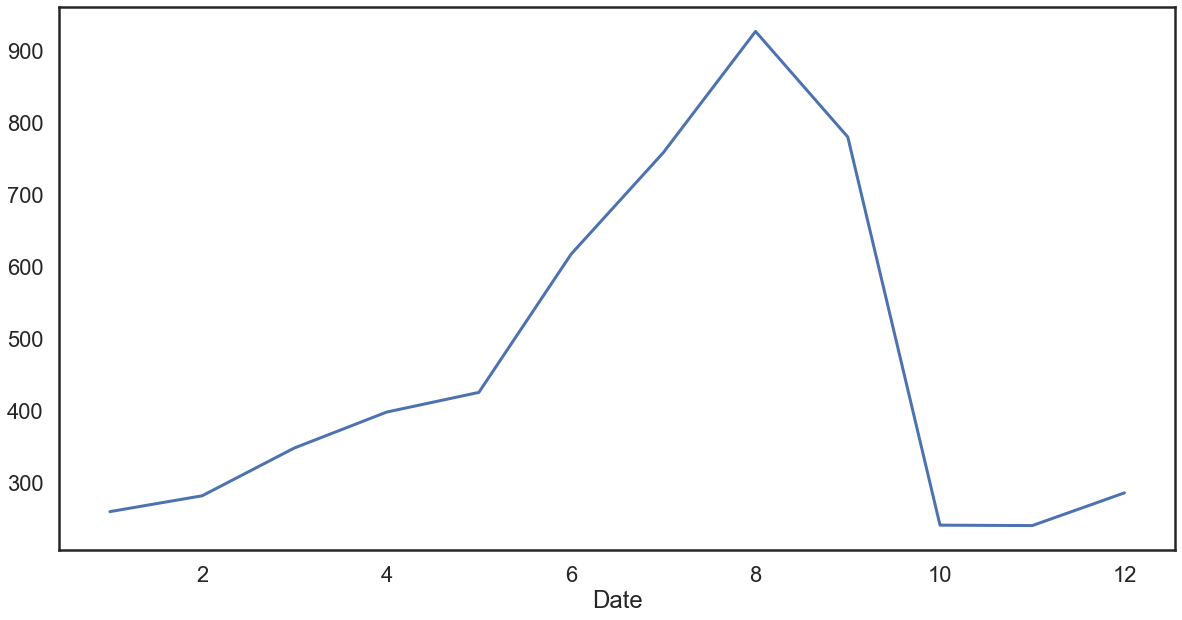

In [116]:
df2.groupby(df2.Date.dt.month)['revenue_7D'].sum().plot()


In [164]:
revenue_per_year = ( df2.groupby(['Station Name', df2.Date.dt.month])['revenue_7D']
                        .mean()
                        .unstack(level=0)
                        .reset_index()
                   )

In [165]:
revenue_per_year = ( pd.melt(revenue_per_year, id_vars="Date")
                        .rename(columns={'value': "revenue ($)"})
                   )

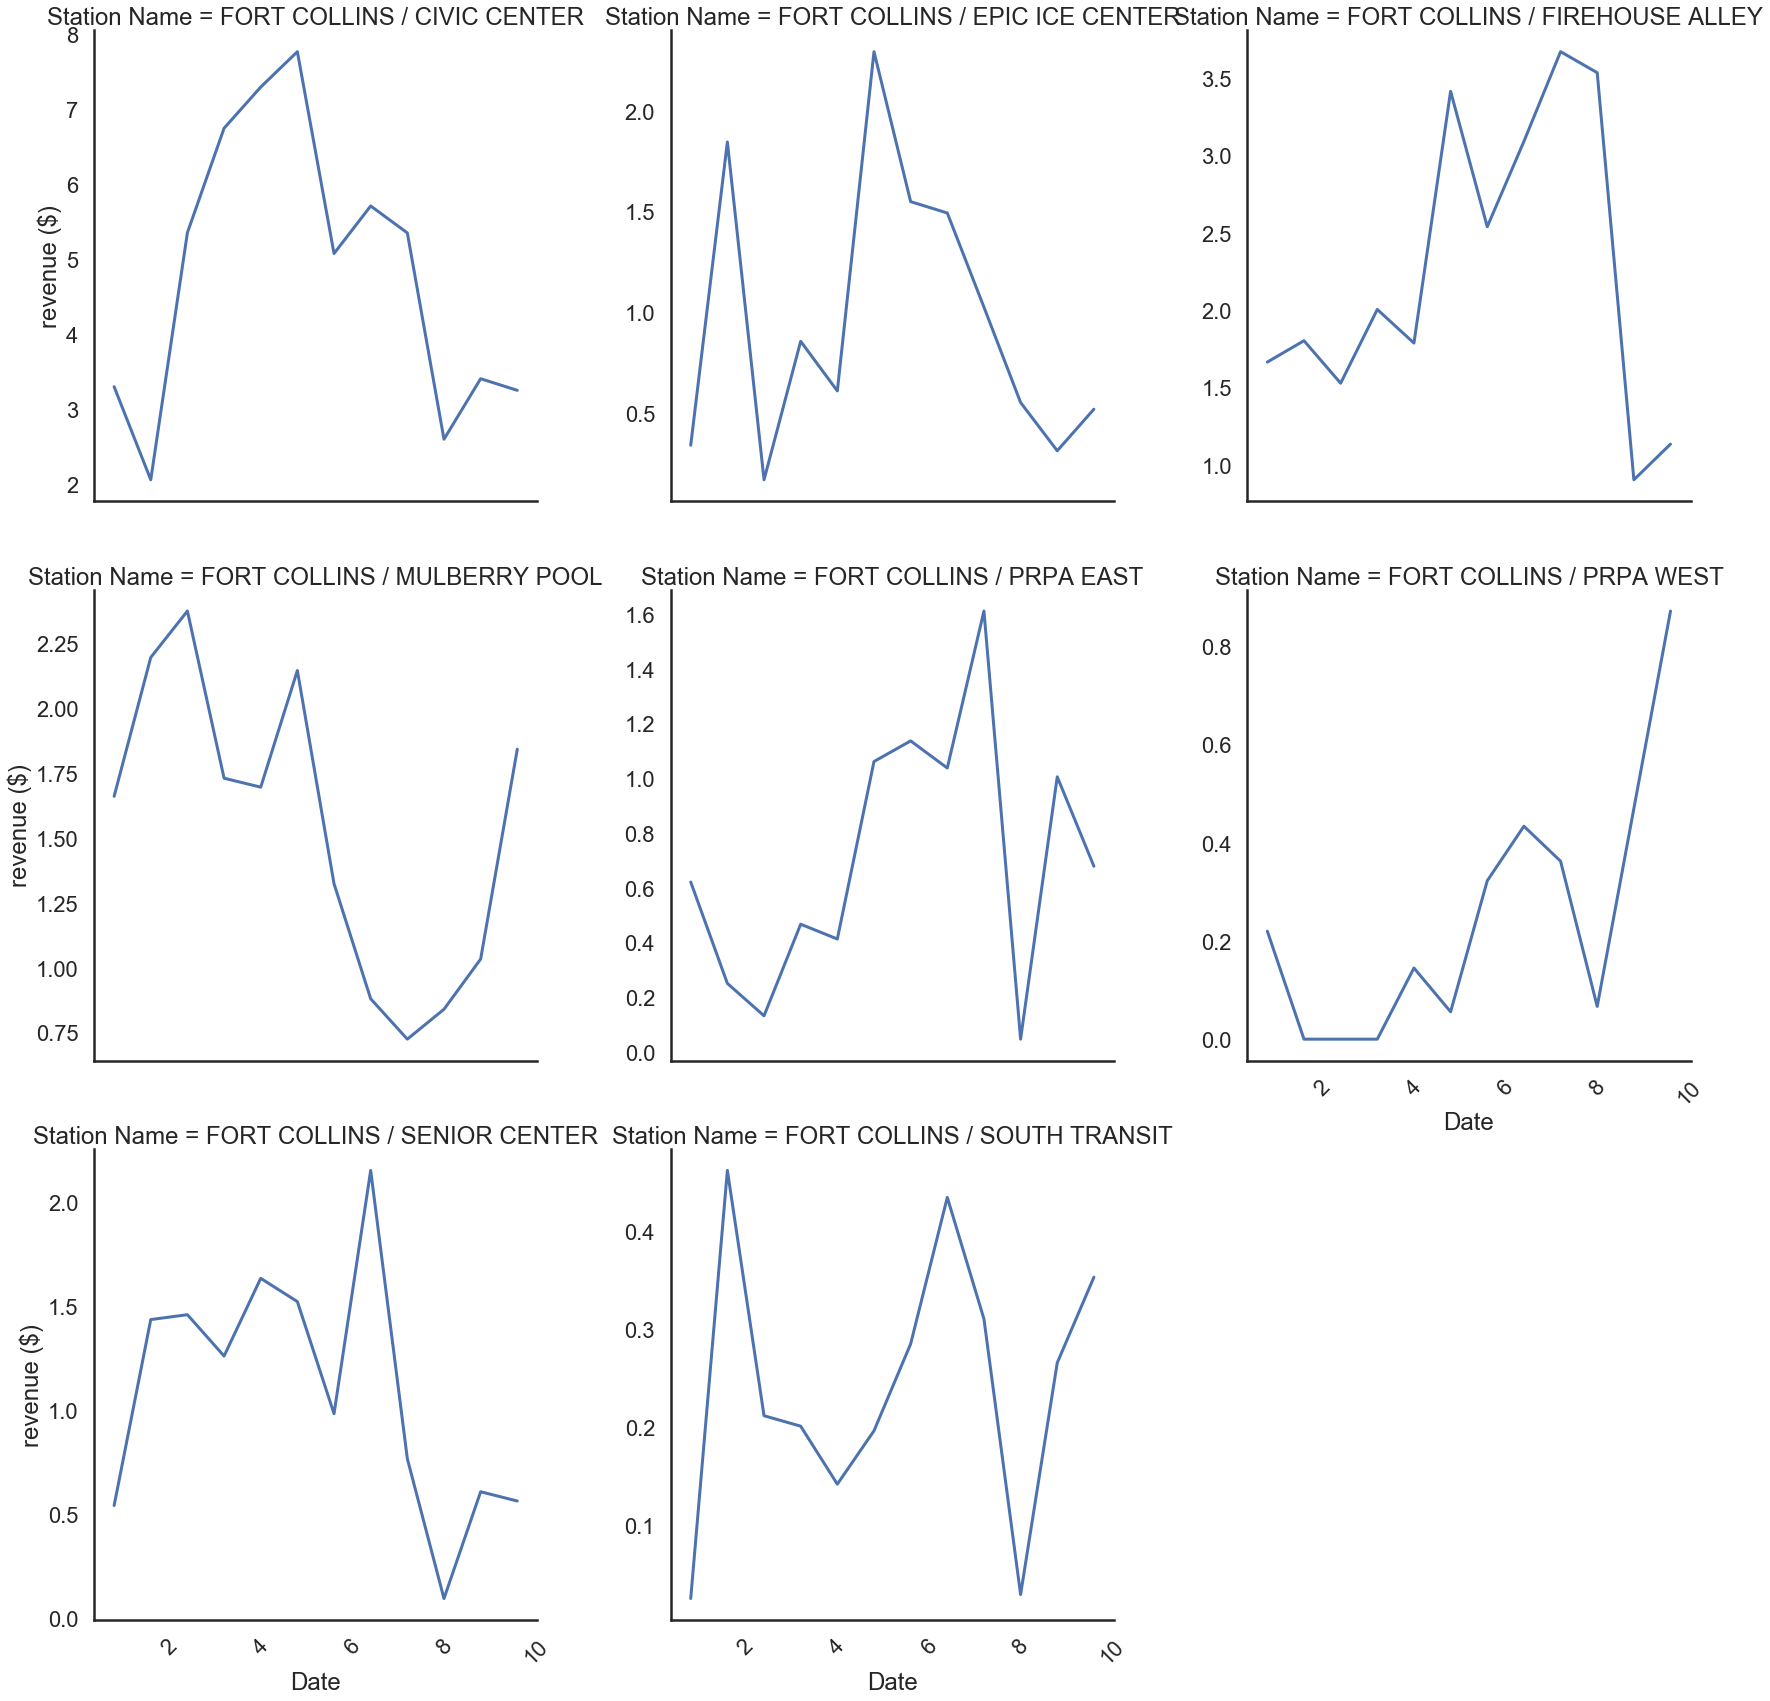

In [166]:
with sns.axes_style("white"):
    g = sns.FacetGrid(revenue_per_year, col="Station Name", margin_titles=True, 
                      height=8, sharey=False, col_wrap=3)
    
g.map(sns.lineplot, "Date", "revenue ($)")
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45);
    
g.add_legend()

In [161]:
revenue_per_year = ( df2.groupby(['Station Name', df2.Date.dt.dayofweek])['revenue_7D']
                        .mean()
                        .unstack(level=0)
                        .reset_index()
                   )

In [162]:
revenue_per_year = ( pd.melt(revenue_per_year, id_vars="Date")
                        .rename(columns={'value': "revenue ($)"})
                   )

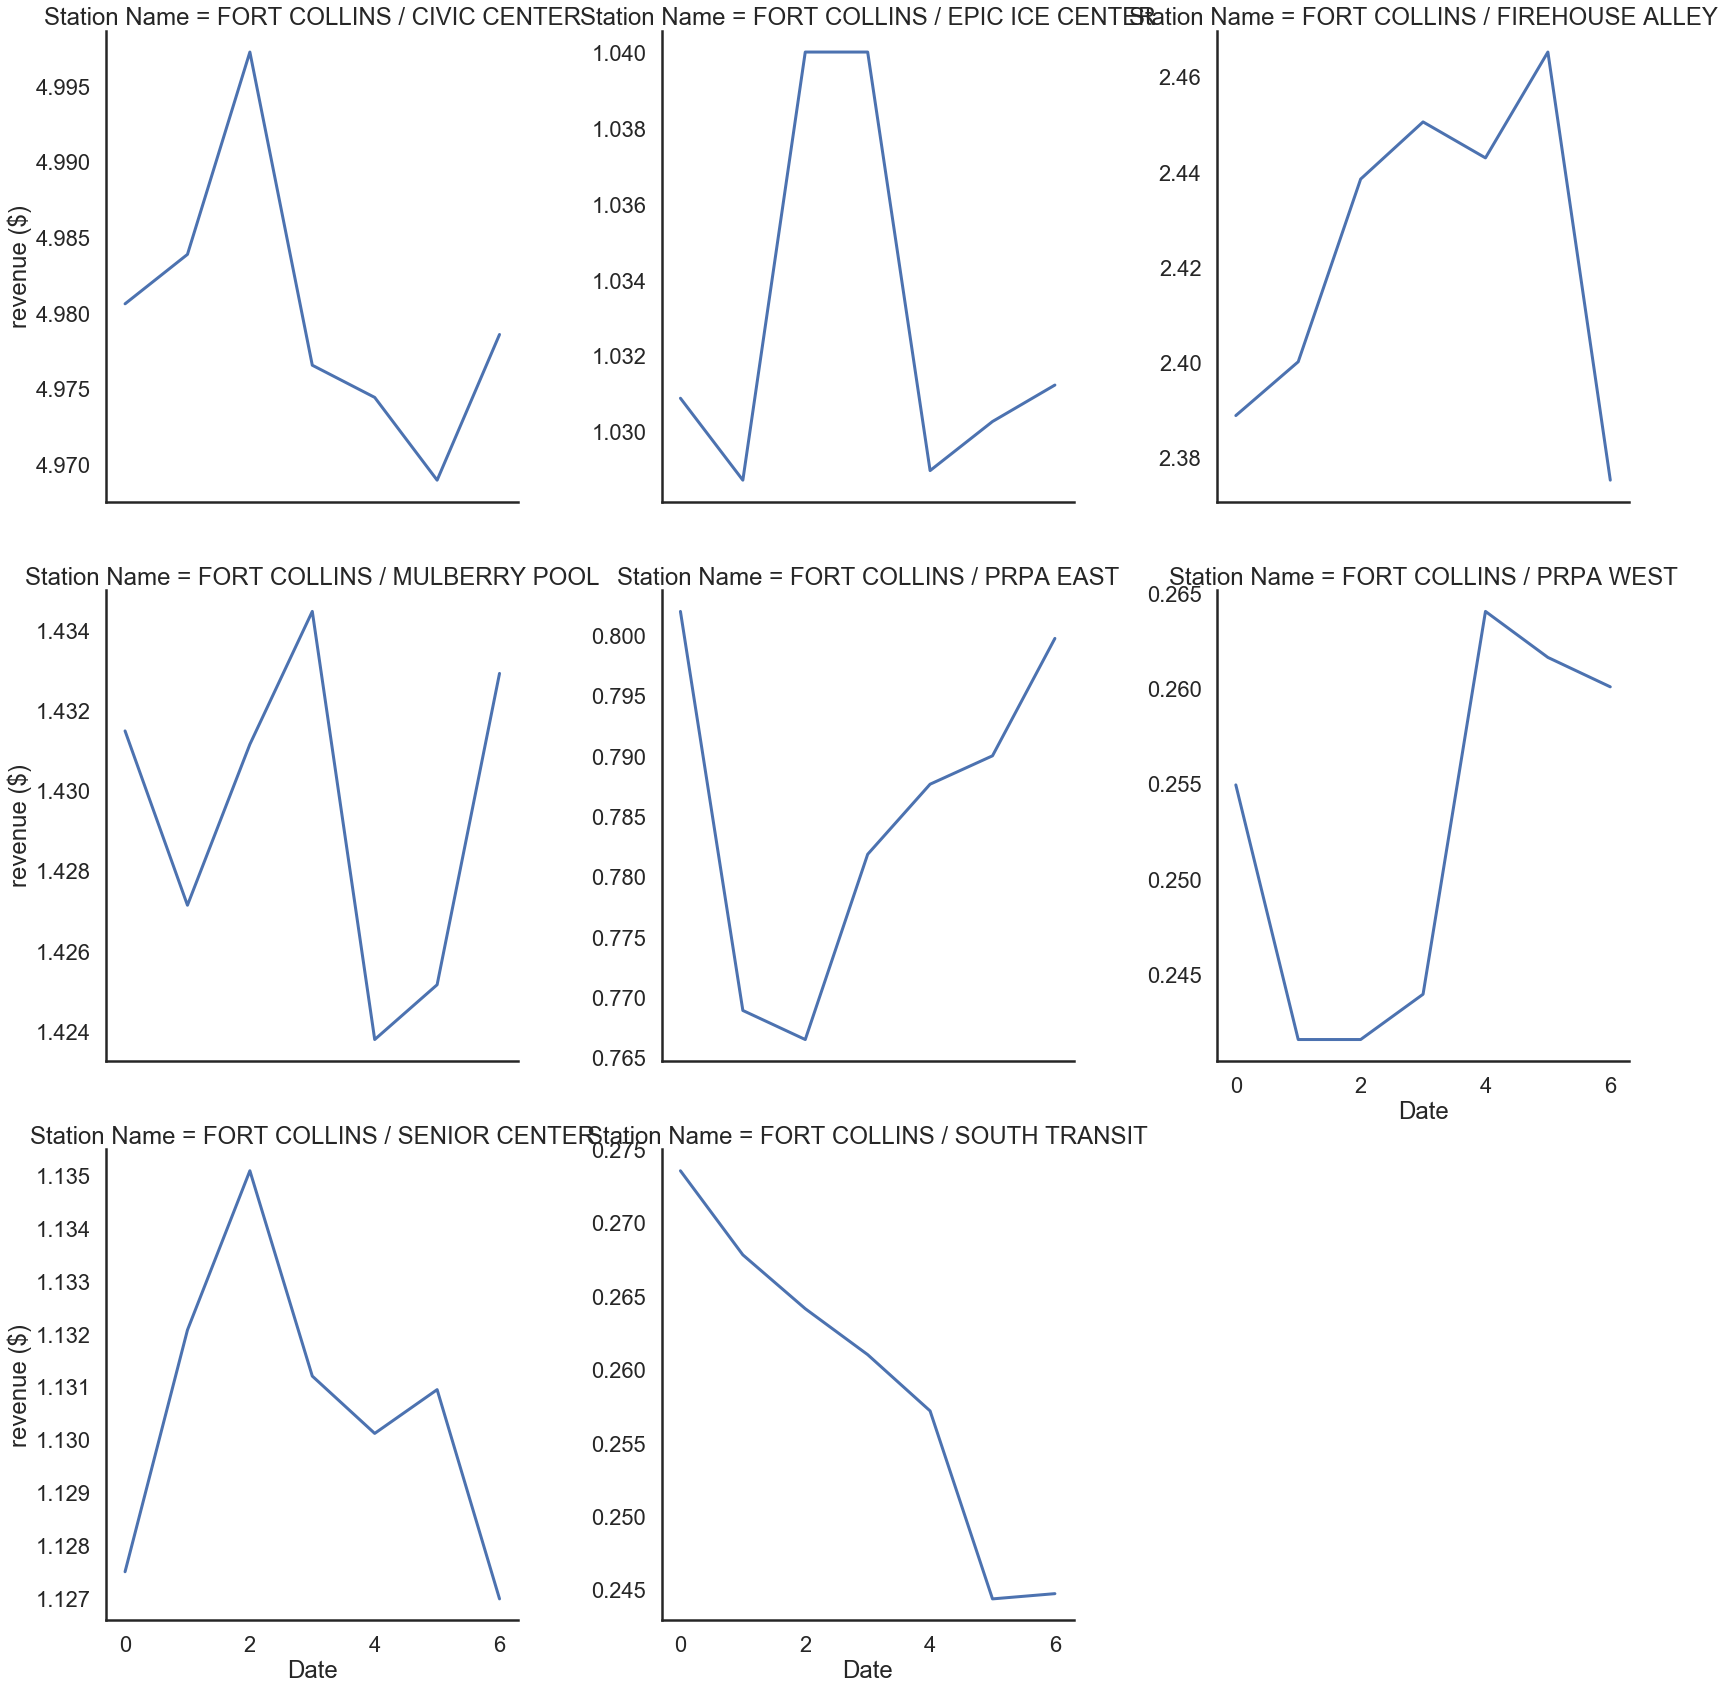

In [163]:
with sns.axes_style("white"):
    g = sns.FacetGrid(revenue_per_year, col="Station Name", margin_titles=True, 
                      height=8, sharey=False, col_wrap=3)
    
g.map(sns.lineplot, "Date", "revenue ($)")
